# Gas Prices

### Setup

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import datetime


from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import month_plot, plot_acf, plot_pacf
from pandas.tools.plotting import autocorrelation_plot

### Data Wrangling

In [2]:
#parsing excel file and renaming columns
file = pd.ExcelFile("future_gas_folder/data/GAS.xls")
df_gas= file.parse('Data 1', header=2, ncolumns=2) 
df_gas = df_gas[['Date', 'Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']]
df_gas = df_gas.rename(index=str,
    columns={"Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)": "gas_price"})

df_gas_adj = pd.read_csv("future_gas_folder/data/gas_inflation_adjusted.csv")
df_gas_adj = df_gas_adj[['Month', 'Real Values']]
df_gas_adj = df_gas_adj.rename(index=str, columns={'Month':'Date', 'Real Values':'adjusted price'})
                           
#dropping NaNs and convert index to datetime
df_gas.dropna(axis=0, inplace=True)
df_gas['Date'] = pd.to_datetime(df_gas.Date)
df_gas.set_index('Date',  inplace=True)

df_gas_adj['Date'] = pd.to_datetime(df_gas_adj.Date)
df_gas_adj.set_index('Date',  inplace=True)
df_gas_adj.sort_index(ascending=True, inplace = True)

### Data Exploration

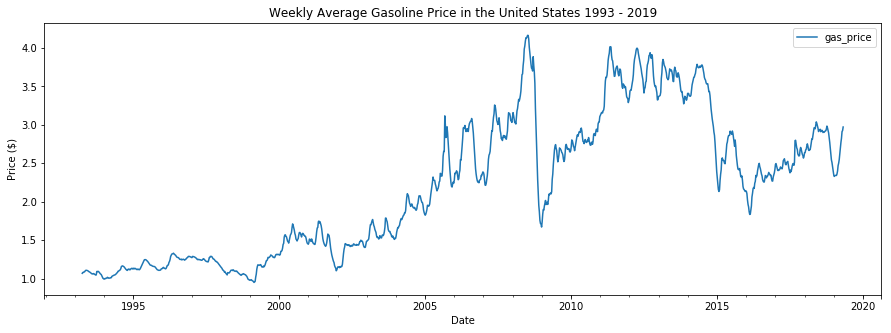

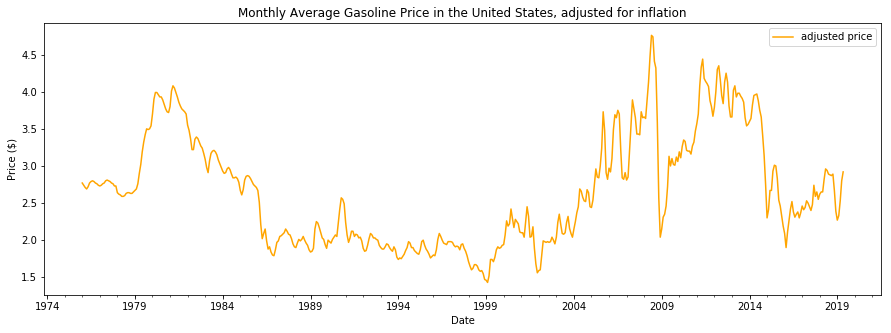

In [3]:
#Plotting
df_gas.plot(figsize = (15, 5))
plt.title('Weekly Average Gasoline Price in the United States 1993 - 2019')
plt.ylabel('Price ($)');
plt.xlabel('Date');

df_gas_adj.plot(figsize = (15, 5), color = 'orange')
plt.title('Monthly Average Gasoline Price in the United States, adjusted for inflation')
plt.ylabel('Price ($)');
plt.xlabel('Date');

We can draw some interesting observations from this plot:
* Slow gradual increase of prices
* Spike and dip at random intervals
* A large dip roughly around the time of the 2008 financial crisis, enforcing our hypothesis that gas prices are related to the state of the US economy. 
* There seems to be an annual spike of varying sizes

 We already know that the series is going to be a heteroscedastic and autocorrelated time series, but let's plot it to confirm.

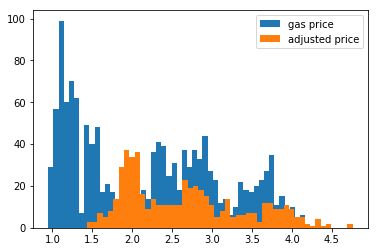

In [4]:
plt.hist(df_gas['gas_price'], 50, label = 'gas price');
plt.hist(df_gas_adj['adjusted price'], 50, label = 'adjusted price');
plt.legend(loc='best');

As exepcted, this is nowhere near a normal distribution.

Let's group by weeks & month to see if there are any seasonal patterns

In [5]:
month_avg = df_gas.groupby(df_gas.index.month).mean()
week_avg = df_gas.groupby(df_gas.index.week).mean()

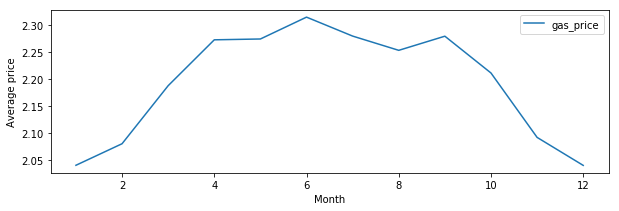

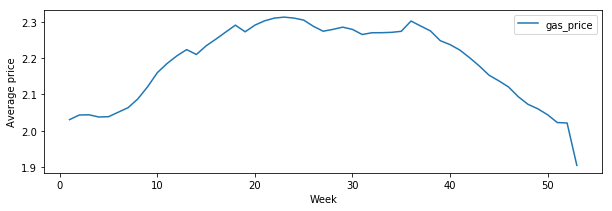

In [6]:
month_avg.plot(figsize = (10, 3))
plt.ylabel('Average price');
plt.xlabel('Month');

week_avg.plot(figsize = (10, 3))
plt.ylabel('Average price');
plt.xlabel('Week');

Comparing week and month averages, it seems that prices go up in the summer. To be more rigorous, we dicided to plot a monthly histogram of prices:

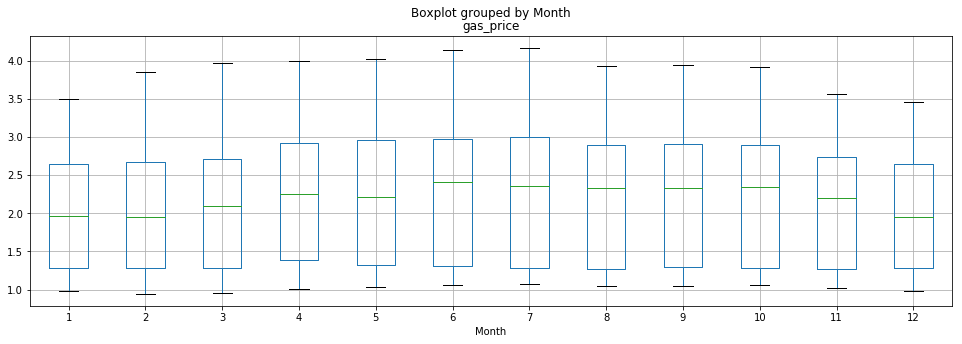

In [7]:
df_seasonal = df_gas.copy()
df_seasonal['Month'] = df_seasonal.index.month
df_seasonal.boxplot(by='Month', figsize = (16, 5));
plt.xlabel('Month');

Very interesting, we can see a graduating increasing in gas prices peaking in the summer, and decrease in prices bottoming in winter. Although there are slight variations in other month, the median price for June is higher than all other months. We explore this further by using a linear decomposition of our time series into a trend component and a seasonality component. The model (from statsmodels library) is as follows:
<h2><center>Y(t) = T(t) + S(t) + ε </center></h2>
Where Y is the dependent variable, T & S are trend & seasonality, and episilon is a random noise term.

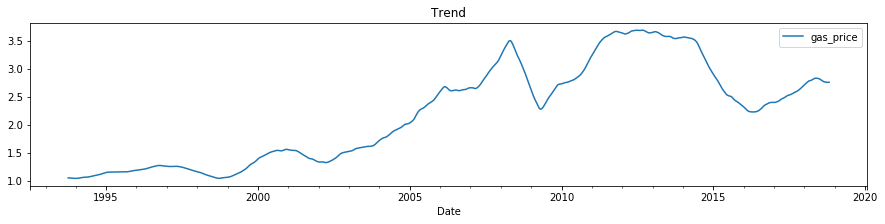

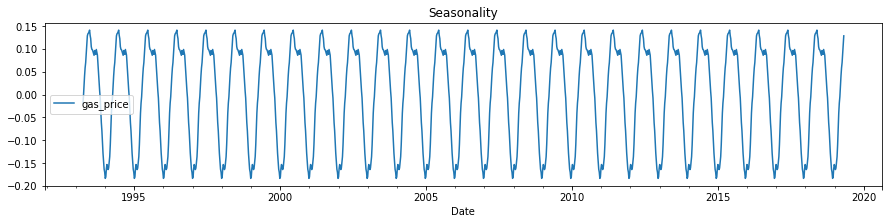

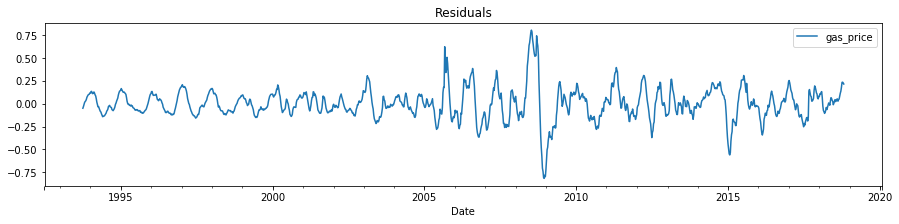

In [8]:
#fig, ax = plt.subplots(figsize=(16, 5))
result = seasonal_decompose(df_gas, model='additive')
result.trend.plot(figsize=(15, 3), title = 'Trend');
result.seasonal.plot(figsize=(15, 3), title = 'Seasonality');
result.resid.plot(figsize=(15, 3), title = 'Residuals');

We can see that stastmodels succefully decomposed our series into a trend component that models the gradual changes as well as a seasonality component with a frequency of one year, with the peak value at mid-year (June), which is what we predicted. We now assess how good is this decomposition. 
From the plot above, the residuals look pretty similar to white noise, we plot it to confirm:

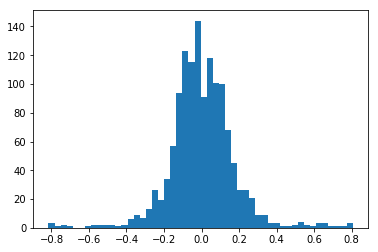

In [13]:
plt.hist(result.resid['gas_price'], 50);

We can see that the residuals are normally distributed, which implies that its probably close to white noise. Unfortunately, we cannot plot the autocorrelation function here because there are too many NaN values in the residual dataframe. We now reconstruct the time series from trend + seasonality and compare it with the original time series.

In [42]:
gas_reconstructed = pd.concat([result.seasonal.add(result.trend, fill_value=0), result.observed], axis=1)
gas_reconstructed.columns = ['reconstructed', 'observed']
rmse = np.sqrt(np.mean(result.resid['gas_price']**2))

Root-Mean Squared Error : 0.17223427610846742


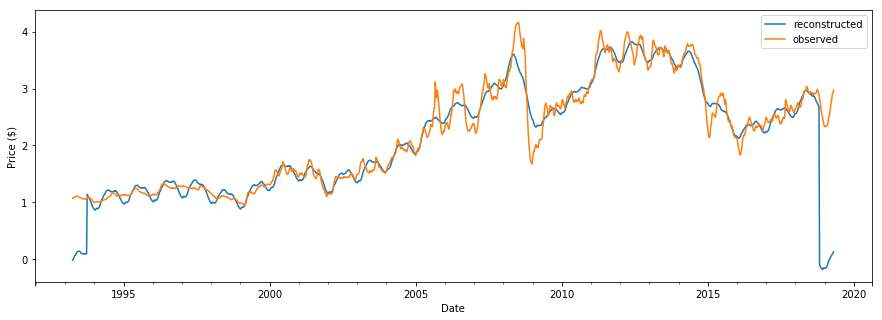

In [44]:
gas_reconstructed.plot(figsize = (15, 5))
plt.ylabel('Price ($)');
plt.xlabel('Date');
print('Root-Mean Squared Error : {}'. format(rmse))

This is a pretty good fit, although we can see that there are some components not explained by this decomposition.

## Predicting Gas Prices

We have adopted the ARIMA model since we are predicting a variable into the future using all the information we have on the past. Multiple linear regression will not work well for this approach for three reasons:
1. Our time series violates the assumption on homoscedacity, its mean and variance chances constantly across time.
2. It's also autocorrelated, which means that the residuals from a OLS fit would not be linear.
3. Multiple linear regression assumes no temporality which is a key component of forecasting. It also cannot predict into the future

### Manual Parameter Selection

#### Order of Differencing (d)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (30,15), sharex=True)
axes[0, 0].plot(df_gas.values); axes[0, 0].set_title('Original Series')
plot_acf(df_gas.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(df_gas.values, axis = 0)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(df_gas.values, axis = 0), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(df_gas.values, axis = 0), axis = 0)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(df_gas.values, axis = 0), axis = 0), ax=axes[2, 1])

plt.show()

In [ ]:
adf_dif0 = adfuller(df_gas['gas_price'])
print('ADF Statistic: %f' % adf_dif0[0], 'p-value: %f' % adf_dif0[1])
adf_dif1 = adfuller(np.diff(df_gas['gas_price'], axis = 0))
print('ADF Statistic: %f' % adf_dif1[0], 'p-value: %f' % adf_dif1[1])
adf_dif2 = adfuller(np.diff(np.diff(df_gas['gas_price'], axis = 0),axis = 0))
print('ADF Statistic: %f' % adf_dif2[0], 'p-value: %f' % adf_dif2[1])

In [ ]:
freqs, pw = sp.signal.welch(np.diff(df_gas['gas_price'].values))
plt.plot(freqs, pw)

We do an ad-fuller test to determine whether the series is stationary, based on above, 1st order differencing is more than enough.

#### Number of lags in the AR model (p)

We plot the PACF of the 1st-differenced prices to see how well lagged observations explain variations in the data

In [ ]:
plot_pacf(np.diff(df_gas['gas_price'], axis = 0), lags = 20);

We can see from this plot that lags 1, 2, 3 , and 4 are significantly above the 95% confidence interval.

#### Number of lagged errors in the MA model (q)

We plot ACF to see how well lagged errors explain variations in the data

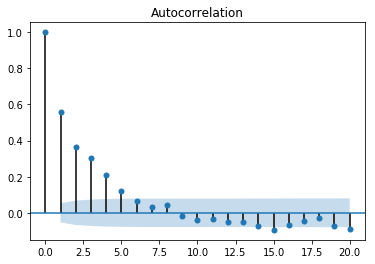

In [16]:
plot_acf(np.diff(df_gas['gas_price'], axis = 0), lags = 20);

### Fitting

In [ ]:
order = np.array([2,1,1])
model = ARIMA(df_gas, order=order)
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
plot_acf(residuals, lags = 20);
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
#plt.figure(figsize=(20,10))
model_fit.plot_predict('2010', '2021', dynamic=False)
plt.show()

### Automatic Parameter Selection

In [ ]:
# Proposal: do a grid search for minmum AIC/BIC or RMSE